In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import json 
import os
import time
from sklearn import model_selection
import importlib.util
spec = importlib.util.spec_from_file_location("Wide_and_Deep_model", "/content/drive/MyDrive/Colab Notebooks/Wide_and_Deep_model.py")
Wide_and_Deep_model = importlib.util.module_from_spec(spec)
spec.loader.exec_module(Wide_and_Deep_model)
Wide_Deep = Wide_and_Deep_model.Wide_Deep

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print("train on device: ", device)

train on device:  cuda:0


In [9]:
riid_all = pd.DataFrame()

for dirname, _, filenames in os.walk('/content/drive/MyDrive/Fellowship.AI/P1_bandit/dataset/datas'):
    for filename in filenames:
        data_path = os.path.join(dirname, filename)
        riid = pd.read_csv(data_path, usecols=['riid'])
        riid_all = pd.concat((riid_all, riid),axis=0)

vocab = {r:i for i, r in enumerate(riid_all.riid.unique())}
print("number of total data points:", len(riid_all))
print("number of unique users:", len(vocab))
del riid, riid_all

number of total data points: 70409094
number of unique users: 1717160


In [10]:
context_columns = ['sends_since_last_open',
                   'retention_score', 
                   'recency_score',
                   'frequency_score',
                   'is_one_for_free', 
                   'is_exclusive', 
                   'free_shipping',
                   'has_urgency', 
                   'sl_contains_price', 
                   'is_discount_mentioned',
                   'campaign_Brand', 
                   'campaign_Core', 
                   'campaign_Dedicated', 
                   'campaign_InnovationSpotlight',
                   'campaign_NewArrivals', 
                   'campaign_ProductSpotlight', 
                   'campaign_Replen',
                   'campaign_Tops', 
                   'campaign_Trend', 
                   'campaign_Other']

In [11]:
# A custumized class of torch dataset for the training
class Mydataset(torch.utils.data.Dataset):
    def __init__(self, df_data):
        self.data = np.array(df_data)

    def __getitem__(self, index):
        context = self.data[index][:-1]
        optimal_action = self.data[index][-1]
        return context, optimal_action

    def __len__(self):
        return self.data.shape[0]

In [12]:
def train_week(device, model, optimizer, loss_func, dataloader, num_epoch=1):
    for i in range(num_epoch):
        model.train()
        corrects = 0.0
        train_loss = 0.0
        for c_train, opt_a_train in dataloader:
            c_train = c_train.float().to(device)
            opt_a_train = opt_a_train.long().to(device)

            pred_out_train = model(c_train)

            loss = loss_func(pred_out_train, opt_a_train)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred_a_train = torch.argmax(pred_out_train, dim=1)
            corrects += torch.sum(pred_a_train==opt_a_train).item()
            train_loss += loss.item() * c_train.shape[0]
    return corrects, train_loss

def valid(device, model, loss_func, dataloader):
    model.eval()
    corrects = 0.0
    losses = 0.0
    pred_actions = None
    opti_actions = None
    for c, opt_a in dataloader:
        c = c.float().to(device)
        opt_a = opt_a.long().to(device)
        pred_out = model(c)
        loss = loss_func(pred_out, opt_a)
        pred_a = torch.argmax(pred_out, dim=1)
        if pred_actions is None:
            pred_actions = pred_a.cpu().numpy().reshape(-1)
            opti_actions = opt_a.cpu().numpy().reshape(-1)
        else:
            pred_actions = np.hstack((pred_actions, pred_a.cpu().numpy().reshape(-1)))
            opti_actions = np.hstack((opti_actions, opt_a.cpu().numpy().reshape(-1)))
        corrects += torch.sum(pred_a==opt_a).item()
        losses += loss.item() * c.shape[0]
    accuracy = corrects/len(dataloader.dataset)
    average_loss = losses/len(dataloader.dataset)

    return accuracy, average_loss, pred_actions, opti_actions

In [13]:
# create a deep-only model and train it
wide_dim = 1
deep_dim = 20
action_dim = 2
embeddings = {'wide':[['user_id', len(vocab), 64]]}
deep_neurons = [128, 64]
model = Wide_Deep(wide_dim, deep_dim, action_dim, embeddings=embeddings, deep_neurons=deep_neurons).to(device)
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

This is a wide and deep model.


In [14]:
num_epoch = 3
for i in range(num_epoch):
    start_time = time.time()
    if i==0:
        df_valid = pd.DataFrame()
    total_corrects = 0.0
    total_loss = 0.0
    total_len = 0
    for dirname, _, filenames in os.walk('/content/drive/MyDrive/Fellowship.AI/P1_bandit/dataset/datas'):
        for filename in filenames:
            data_path = os.path.join(dirname, filename)
            df_week = pd.read_csv(data_path, usecols=['riid']+context_columns+['optimal_action'])
            df_week['riid'] = df_week.riid.apply(lambda x:vocab[x])
            df_week_train, df_week_valid = model_selection.train_test_split(df_week, train_size=0.95, random_state=33)
            if i==0:
                df_valid = pd.concat((df_valid, df_week_valid), axis=0)
            batch_size = 8192
            dataset = Mydataset(df_week_train)
            dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
            corrects_week, loss_week = train_week(device, model, optimizer, loss_func, dataloader)
            total_corrects += corrects_week
            total_loss += loss_week
            total_len += len(dataset)

    train_accuracy = total_corrects/total_len
    train_average_loss = total_loss/total_len
    print("Epoch:{:>4}\t Training Loss: {:6.3f}\t Training Accuracy: {:.3f}\t time used: {:.3f} sec".format(i+1, train_average_loss, train_accuracy, time.time()-start_time))
    start_time = time.time()
    dataset = Mydataset(df_valid)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)
    valid_accuracy, valid_average_loss, pred_as, opti_as= valid(device, model, loss_func, dataloader)
    print("Epoch:{:>4}\t Valid Loss: {:6.3f}\t Valid Accuracy: {:.3f}\t time used: {:.3f} sec".format(i+1, valid_average_loss, valid_accuracy, time.time()-start_time))


Epoch:   1	 Training Loss:  0.340	 Training Accuracy: 0.861	 time used: 1104.543 sec
Epoch:   1	 Valid Loss:  0.343	 Valid Accuracy: 0.861	 time used: 28.449 sec
Epoch:   2	 Training Loss:  0.323	 Training Accuracy: 0.869	 time used: 1075.487 sec
Epoch:   2	 Valid Loss:  0.334	 Valid Accuracy: 0.866	 time used: 27.632 sec
Epoch:   3	 Training Loss:  0.318	 Training Accuracy: 0.870	 time used: 1069.447 sec
Epoch:   3	 Valid Loss:  0.332	 Valid Accuracy: 0.866	 time used: 27.570 sec


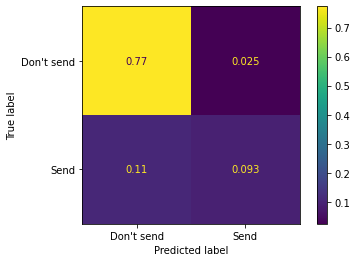

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(opti_as, pred_as, normalize='all', labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Don\'t send', 'Send'])
disp.plot() 